Cell 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cell 2: Imported the Libraries & GPU Check

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Verifying GPU is detected
print("GPU Available:", len(tf.config.list_physical_devices('GPU')))

GPU Available: 1


Cell 3: Loading Dataset from Google Derive

In [3]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

# Loading data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/MSAI_Project/My Project DATA",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2169 files belonging to 3 classes.


Cell 4: Verifying Classes

In [4]:
class_names = dataset.class_names
print("Classes found:", class_names)

Classes found: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


Cell 5: Split the Data

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

# Createing the partitions
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training Batches: {len(train_ds)}")
print(f"Validation Batches: {len(val_ds)}")
print(f"Testing Batches: {len(test_ds)}")

Training Batches: 54
Validation Batches: 6
Testing Batches: 8


Cell 6: Augmentation & Optimization of Data

In [6]:
# 1. Defining Augmentation Layer (Flip & Rotate)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# 2. Defining Rescaling Layer (0-255 -> 0-1)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

# 3. Applying settings to the datasets
# We only apply augmentation to Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation and Testing data just need to be fast
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data pipeline is ready!")

Data pipeline is ready!


Cell 7: Defining the CNN Model Architecture

In [15]:
# 7: Defining the CNN Model Architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    # Expliciting Input Layer
    layers.Input(shape=input_shape),

    # Preprocessing layers
    resize_and_rescale,

    # Convolutional Layers
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

Cell 8: Viewing Model Summary

In [16]:
# 8: Model Summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Cell 9: Compiling the Model

In [20]:
# 9: Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Cell 10: Train the Model

In [21]:
# 10: Training the Model
EPOCHS = 50

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 885s 529ms/step - accuracy: 0.4661 - loss: 0.9278 - val_accuracy: 0.7656 - val_loss: 0.7819
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.6796 - loss: 0.7455 - val_accuracy: 0.7946 - val_loss: 0.4808
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.8092 - loss: 0.4506 - val_accuracy: 0.9115 - val_loss: 0.2372
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.8905 - loss: 0.2706 - val_accuracy: 0.9479 - val_loss: 0.1816
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 479ms/step - accuracy: 0.9152 - loss: 0.2023 - val_accuracy: 0.9531 - val_loss: 0.1597
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.9278 - loss: 0.1947 - val_accuracy: 0.9271 - val_loss: 0.1988
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 479ms/step - accuracy: 0.9295 - loss: 0.1961 - val_accuracy: 0.9531 - val_loss: 0.1014
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 484ms/step - accuracy: 0.9461 - loss: 0.1526 - val_acc

Cell 11: Visualize the Training Results

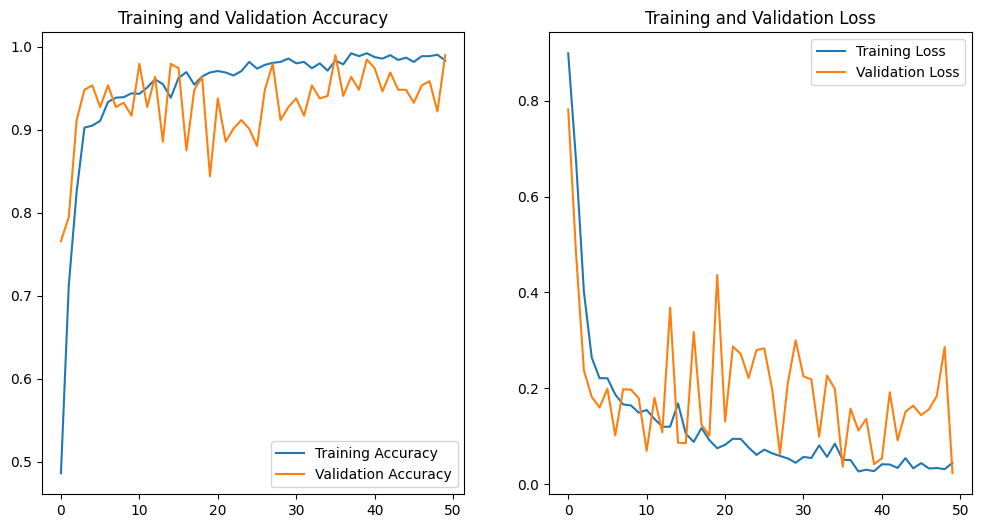

In [22]:
# 11: Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Cell 12: Final Evaluation (The "Test")

In [23]:
# 12: Evaluating on Test Data
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1] * 100, 2)}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9766 - loss: 0.0481
Test Accuracy: 97.66%


13: Saving the Model

In [25]:
# 13: Saving the Model to Google Drive
import os

# Creating a models folder if it doesn't exist
model_path = "/content/drive/MyDrive/MSAI_Project/models"
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Saving the model
model.save(f"{model_path}/potato_disease_model_v1.keras")
print(f"Model saved successfully to {model_path}")

Model saved successfully to /content/drive/MyDrive/MSAI_Project/models
